# TP 1 : FINA60206 - Produits Dérivés - 11/02/2022
    Idriss Wannassy - 11237451
    Yissan Yaro     - 11222222

In [1]:
# Installer les packages necessaires : 
import sys
!{sys.executable} -m pip install quadpy
!{sys.executable} -m pip install opstrat

     |████████████████████████████████| 1.3 MB 11.4 MB/s            
     |████████████████████████████████| 50 kB 3.9 MB/s             
     |████████████████████████████████| 292 kB 38.5 MB/s            
     |████████████████████████████████| 6.4 MB 35.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=54a50afdfe153809462c7b27977da3811c3d4a4917ab0117ac5c15b6d6653d2c
  Stored in directory: /home/jovyan/.cache/pip/wheels/15/e6/fa/f4bf8d84e804547b3c1b1d4b09a671768502b32ca33ec60651
Successfully built multitasking


On importe les librairies, on definit les fonctions et on initialise les paramètres qu'on va utiliser dans le code : 

In [2]:
#Librairies : 
import numpy as np
from scipy.stats import norm
import opstrat as op
from scipy import optimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time as tm
import scipy.optimize as opt
import quadpy

In [3]:
# Fonctions : 
    # Fonction BS : calcul le prix d'une option call ou put avec t qui controle pour le type (call ou put)
def BS(S,K,T,vol,r,t):
    d1= (np.log(S/K)+T*(r + 0.5*vol**2))/(vol*np.sqrt(T))
    d2= d1 - vol*np.sqrt(T)
    if t =="c":
        p = (S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*T))
    elif t == "p" :
        p = (K*norm.cdf(-d2)*np.exp(-r*T) - S*norm.cdf(-d1))
    return p
        
    # Fonction qui calcule la valatilitee implicite : 
def IV(S,K,T,r,marketoptionPrice):
    def bs_price(sigma):
        fx=BS(S,K,T,sigma,r,"p")-marketoptionPrice
        return fx
    return optimize.brentq(bs_price,0.0001,100,maxiter=1000)
###Utilisation de l'algorithme de root-finding de brent pour accélérer la convergence au vu de la forme de la fonction


    #Fonction de tarification du put en utilisant un arbre binomial : 
    # typ controle si c'est un put europeen ou americain (e ou a), aj controle avec ou sans ajustement de BS(yes or no) : 

def put_binomial(S,T,K,r,sigma,n,typ,aj):
    # Valeur de l'incrément de temps
    delta=T/n
    # Calcul de u, d et q
    u=np.exp(sigma*delta**0.5)
    d=1/u
    q=(np.exp(r*delta)-d)/(u-d)
    qd = 1 - q
    
    if typ == 'e' and aj == 'no':
        # Initialisation de la somme
        somme=0
        # Initialisation de la combinaison et de l'incrément servant à son calcul
        c=1
        increment_c=0
        # Calcul de la somme par itération
        for j in range(n+1):
            somme=somme+max(K-S*u**j*d**(n-j),0)*c*q**j*(1-q)**(n-j)
            # Mise à jour de la combinaison
            c=c*(n-increment_c)/(increment_c+1)
            increment_c=increment_c+1
        # Calcul de la valeur du put
        put=np.exp(-r*T)*somme
    elif typ == 'e' and aj == 'yes' :
        somme=0
        # Initialisation de la combinaison et de l'incrément servant à son calcul
        c=1
        increment_c=0
        # Calcul de la somme par itération
        for j in range(n):
            somme=somme+BS(S*u**j*d**(n-j),K,delta,sigma,r,'p')*c*q**j*(1-q)**(n-j)
            # Mise à jour de la combinaison
            c=c*(n-increment_c)/(increment_c+1)
            increment_c=increment_c+1
        # Calcul de la valeur du put
        put=np.exp(-r*T)*somme
    elif typ == 'a' and aj == 'no' : 
        Terminal_Value = np.zeros(n+1)
        Middle_Value = np.zeros(n+1)
        for j in range(n+1):
            Terminal_Value[j]= max(K-S*(u**j)*(d**(n-j)),0)
        
        for time in reversed(range(n)): 
            np.resize(Middle_Value,time)
            for state in range(time+1):
                Middle_Value[state] = max(K - S*u**state*d**(time-state),qd*Terminal_Value[state] + q*Terminal_Value[state+1])
            np.resize(Terminal_Value,time)
            
            for state in range(time+1):
                Terminal_Value[state] = Middle_Value[state]
        put = Terminal_Value[0]
    elif typ == 'a' and aj == 'yes' :
        Terminal_Value = np.zeros(n)
        Middle_Value = np.zeros(n)
        for j in range(n):
            Terminal_Value[j]= BS(S*u**j*d**(n-1-j),K,delta,sigma,r,'p')
        
        for time in reversed(range(n-1)): 
            np.resize(Middle_Value,time)
            for state in range(time+1):
                Middle_Value[state] = max(K - S*u**state*d**(time-state),qd*Terminal_Value[state] + q*Terminal_Value[state+1])
            np.resize(Terminal_Value,time)
            
            for state in range(time+1):
                Terminal_Value[state] = Middle_Value[state]
        put = Terminal_Value[0]
    else:
        put = 're-enter appropriate parameters'
               
    return put

##Fonction que nous optimiserons a la Question 5 afin de trouver la frontière d'exercice. Sa résolution pour S nous donne le pix optimal d'exercice anticipé pour une maturité résiduelle T donnée
def B(S,T,K,r,sigma,n,typ,aj):
    return put_binomial(S,T,K,r,sigma,n,typ,aj) + S -K

# Fonction qui calcule la moneyness :
def moneyness(S,K,T,vol,r):
    return 0.5- norm.cdf((np.log(S/K)+T*(r + 0.5*vol**2))/(vol*np.sqrt(T)))

# Fonctions qui calculent la frontière d'exercice avec la forme quasi-analytique de Carr-Jarrow-Myneni.

def m(r,sigma,tau):
    def mfunc(m):
        def erf(x):
            return 2*norm.cdf(x*np.sqrt(x))-1
        def beta(tau):
            return 0.75*sigma-0.5*r/sigma + 0.5*m/(2*np.sqrt(tau))
        
        return sigma*np.exp(-(r +0.5*sigma**2)*tau-sigma*np.sqrt(tau)*m)*norm.cdf(-m) -r*(erf(np.sqrt(r+0.5*beta(tau)**2)*tau))/(np.sqrt(2*r+beta(tau)**2))
    return optimize.brentq(mfunc,0.0001,100,maxiter=1000)    

def Bt(K,r,sigma,tau):
    return K*np.exp(-(r+0.5*sigma**2)*tau -sigma*np.sqrt(tau)*m(r,sigma,tau))

In [4]:
# Paramètres  :
S_TP = 100
T_TP = 30/365
r_TP= 0.03
vol_hist = 0.35
K = np.array(range(90,115,5))
marketprices = [2.1809,2.5394,4.1029,6.7978,11.0215]

Reponses aux questions : 

Question 1 : Calcul de la volatilité implicite et de la moneyness 

Afin de calculer la moneyness nous utilisons la fonction définie dans le TP : 0.5-N(d1)
En ce qui concerne la volatilité implicite nous la bootstrap en retrouvant la racine de la fonction (sigma) : 
c'est a dire f(sigma) = BS(S,K,T,sigma,r,"p") - prix de marché de l'option = 0 
Afin d'optimiser le temps de calcul on utilise, au vu de la forme de la fonction, la méthode de Brent afin de retrouver le zero de la fonction. 

Text(0, 0.5, 'Implied Volatility in %')

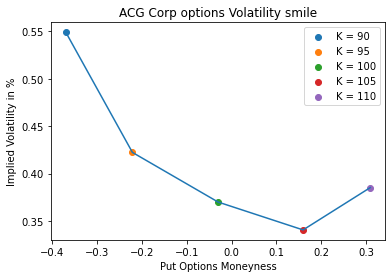

In [5]:
IV_v = np.empty([5])

##Boucle qui Bootstrap les Vol Implicites avec notre fonction IV pour chacun des K demandés 
for i in range(0,5): 
    IV_v[i] = IV(S_TP,K[i],T_TP, r_TP, marketprices[i])
Moneyness_vector = [moneyness(S_TP,i,T_TP,vol_hist,r_TP) for i in K]

# Plot du smile de la volatilité implicite en fonction de la moneyness : 
plt.plot(Moneyness_vector,IV_v)
for i in range(0,5):
    plt.scatter(Moneyness_vector[i],IV_v[i],label = 'K = ' + str(K[i]))
plt.legend()
plt.title('ACG Corp options Volatility smile')
plt.xlabel('Put Options Moneyness')
plt.ylabel('Implied Volatility in %')

Ainsi nous obtenons le smile de volatilité ci-haut. On remarque que la volatilité implicite est décroissante sur l'intervalle de moneyness -0.4 à 0.15 (de facon équivalente : K=90 à K = 105) avec une forte décroissance sur le début de l'intervalle puis par la suite redevient croissante. 

La volatilité implicite n'est donc pas constante et est différente pour chaque prix d'exercice (moneyness également). C'est donc le bon paramètre qui dans le mauvais modèle donne le prix observé dans le marché. 

Question 2 : Calcul de la volatilité implicite en utilisant une interpolation linéaire des puts ayant K = 92.50, 97.50, 102.50 et 107.50.

Nous utilisons la fonction interp1d du package scipy qui permet de faire de l'interpolation linéaire. Ce cas est néanmoins assez simple car les K se retrouvent au milieu de 2 points donc ce n'est que 0.5 * volatilité implicite1 + 0.5 * volatilité implicite2. 

In [6]:
interp = interp1d(K,IV_v) ###estimation de la fonction d'interpolation avec les K et Volatilités implicites déja connus
Vol_Imp = [interp(i) for i in [92.5,97.5,102.5,107.5]] ##Interpolation de la Vol Implicite pour les 4 puts inconnus

print('Put option Strike price','     Interpolated Implied Volatility')
[print(K[i], '                       :        ', Vol_Imp[i], '\n') for i in range(4)]

Put option Strike price      Interpolated Implied Volatility
90                        :         0.4856427445234064 

95                        :         0.3961830275370113 

100                        :         0.3553535899310501 

105                        :         0.36294600976349944 



[None, None, None, None]

Nous obtenons les résultats ci-dessus. 

Question 3 : Géneration des graphiques de convergence des puts : K = 90, 95, 97.50 ,100, 105 𝑒𝑡 110. 

Pour ce faire, on calcul les prix des puts européens en utilisant la formule de Black & Scholes via la fonction BS qu'on a définit plus haut, puis par la suite on calcule les prix obtenus via un l'arbre binomial CRR et on calcule l'erreur relative comme étant : (prix binomial - prix B&S) * 100 / (prix B&S)

Notez que notre fonction put_binomial prend comme paramètre le type ('e' : option européenne et 'a' : américaine) et si cela est fait avec 'yes' ou sans 'no' ajustement BMS à l'avant-dernier noeud.  

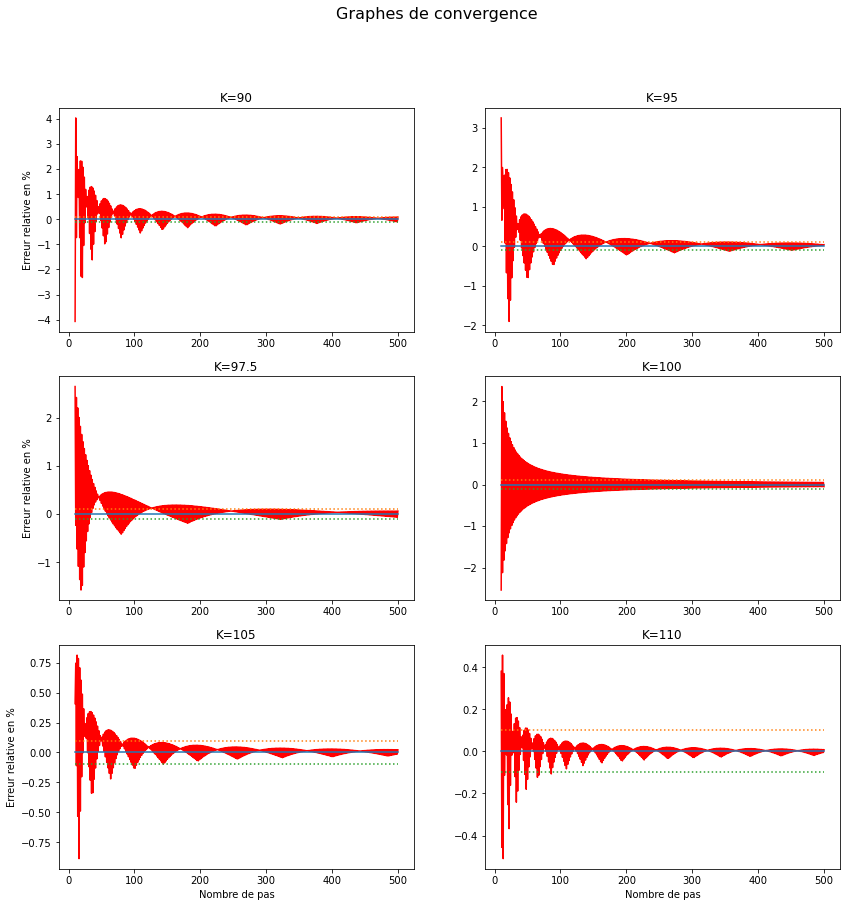

In [7]:
IV6 = interp(97.5)

strikes = [90,95,97.5,100,105,110]
put_prices = [[], [], [], [], [], []]
put_BSprices = [0,0,0,0,0,0]
IV_vector = [IV_v[0],IV_v[1],IV6,IV_v[2],IV_v[3],IV_v[4]]
erreur = []
vec_pas = range(10,501) ##Vecteur contenant les nombres de pas

##Boucle pour calculer/stocker les prix CRR et black-scholes des 6 puts européens en fonction du nombre de pas 
j = 0
for i in strikes:
    put_prices[j] = [put_binomial(S_TP, T_TP, i, r_TP, IV_vector[j], n,'e','no') for n in vec_pas]
    put_BSprices[j] = BS(S_TP,i,T_TP,IV_vector[j],r_TP,"p")
    j = j + 1

erreur = [100*(put_prices[n] - put_BSprices[n])/put_BSprices[n] for n in range(6)]

fig,ax= plt.subplots(3,2,figsize=(14,14))

ax0,ax1,ax2,ax3,ax4,ax5=ax.flatten()

ax0.plot(vec_pas,erreur[0],'r')
ax0.plot(vec_pas,np.zeros(491),'-')
ax0.plot(vec_pas,0.1*np.ones(491),':')
ax0.plot(vec_pas,-0.1*np.ones(491),':')
ax0.set_ylabel("Erreur relative en %")
ax0.set_title("K=90")

fig.suptitle('Graphes de convergence', fontsize=16)

ax1.plot(vec_pas,erreur[1],'r')
ax1.plot(vec_pas,np.zeros(491),'-')
ax1.plot(vec_pas,0.1*np.ones(491),':')
ax1.plot(vec_pas,-0.1*np.ones(491),':')
ax1.set_title("K=95")

ax2.plot(vec_pas,erreur[2],'r')
ax2.plot(vec_pas,np.zeros(491),'-')
ax2.plot(vec_pas,0.1*np.ones(491),':')
ax2.plot(vec_pas,-0.1*np.ones(491),':')
ax2.set_ylabel("Erreur relative en %")
ax2.set_title("K=97.5")

ax3.plot(vec_pas,erreur[3],'r')
ax3.plot(vec_pas,np.zeros(491),'-')
ax3.plot(vec_pas,0.1*np.ones(491),':')
ax3.plot(vec_pas,-0.1*np.ones(491),':')
ax3.set_title("K=100")

ax4.plot(vec_pas,erreur[4],'r')
ax4.plot(vec_pas,np.zeros(491),'-')
ax4.plot(vec_pas,0.1*np.ones(491),':')
ax4.plot(vec_pas,-0.1*np.ones(491),':')
ax4.set_xlabel("Nombre de pas")
ax4.set_ylabel("Erreur relative en %")
ax4.set_title("K=105")

ax5.plot(vec_pas,erreur[5],'r')
ax5.plot(vec_pas,np.zeros(491),'-')
ax5.plot(vec_pas,0.1*np.ones(491),':')
ax5.plot(vec_pas,-0.1*np.ones(491),':')
ax5.set_xlabel("Nombre de pas")
ax5.set_title("K=110")
plt.show()

On remarque divers points : 

1) Plus le prix d'exercice est élevé plus le prix obtenue via l'arbre binomiale converge plus rapidement vers le prix obtenu par BMS, ainsi l'erreur relative tend vers 0 plus rapidement. Également l'erreur relative meme avec un faible nombre de pas est trés faible quand K est grand qu'avec un plus petit K. Par exemple quand K=110 avec 1 pas l'erreur relative commence aux alentours de 0.5% alors que quand K=90 elle est d'environ 4% avec un faible nombre de pas.

On peut expliquer cela par le fait que quand K est trés grand pour un put Européen, l'action est deep in the money et donc la majorité de noes payoffs terminaux seront positifs meme si le prix du sous jacent augmente. Ce qui représente mieux l'univers de possibilité que si l'action est at the money et ainsi la possibilité d'une montée de prix du sous-jacent peut rendre l'action out of the money et avoir des payoffs terminaux nuls ceci ou inversement alors qu'on a besoin de richesse de valeurs terminuax (grands nombre de pas) afin de modéliser plus fidèlement la réalité du processus de prix ainsi des payoffs aux noeufs terminaux. Car par exemple avec une action at the money et 1 pas on aura un payoff nul et 1 payoff positifs aux valeurs terminales alors qu'en réalité avec une augmentation du nombre de pas la proportions de payoffs nul et de payoffs positifs ne sera trés fort probablement pas 50% - 50%. Alors qu'avec une option deep in the money il se peut qu'avec 2 noeuds on ait 2 payoffs aux noeux terminaux positifs ce qui est plus proche de la réalité d'une action at the money. 

2) Ces graphiques confirment la convergence oscillatoire vers le prix de BMS. 
3) Pour K=90, meme avec 500 pas on reste hors de l'intervalle : (-0.1% ; 0.1%) il faudra donc un plus grand nombre de pas. 
4) Les amplitudes des oscillations changes d'un prix d'exercice a un autre et d'un intervalle de pas a un autre. 

Question 4 : 

    Partie 1 : Calcul prix CRR put europeen 97,5 avec et sans ajustement : 

In [8]:
put_a = put_binomial(S_TP, T_TP, 97.5,r_TP, IV6, 500, 'e', 'no')
put_b = put_binomial(S_TP, T_TP, 97.5,r_TP, IV6, 500, 'e', 'yes')

print('prix CRR du put K = 97.5 sans ajustement BMS = ', put_a,'\nprix CRR du put K = 97.5 avec ajustement BMS =', put_b)

prix CRR du put K = 97.5 sans ajustement BMS =  3.2316834957343787 
prix CRR du put K = 97.5 avec ajustement BMS = 3.2343760588747577


Nous obtenons les prix ci-dessus. 

    Partie 2 : Génerer les graphiques demandés : 

In [9]:
##Prix BS put européen
BS(S_TP,97.5,T_TP,IV6,r_TP,"p")

3.229551687075464

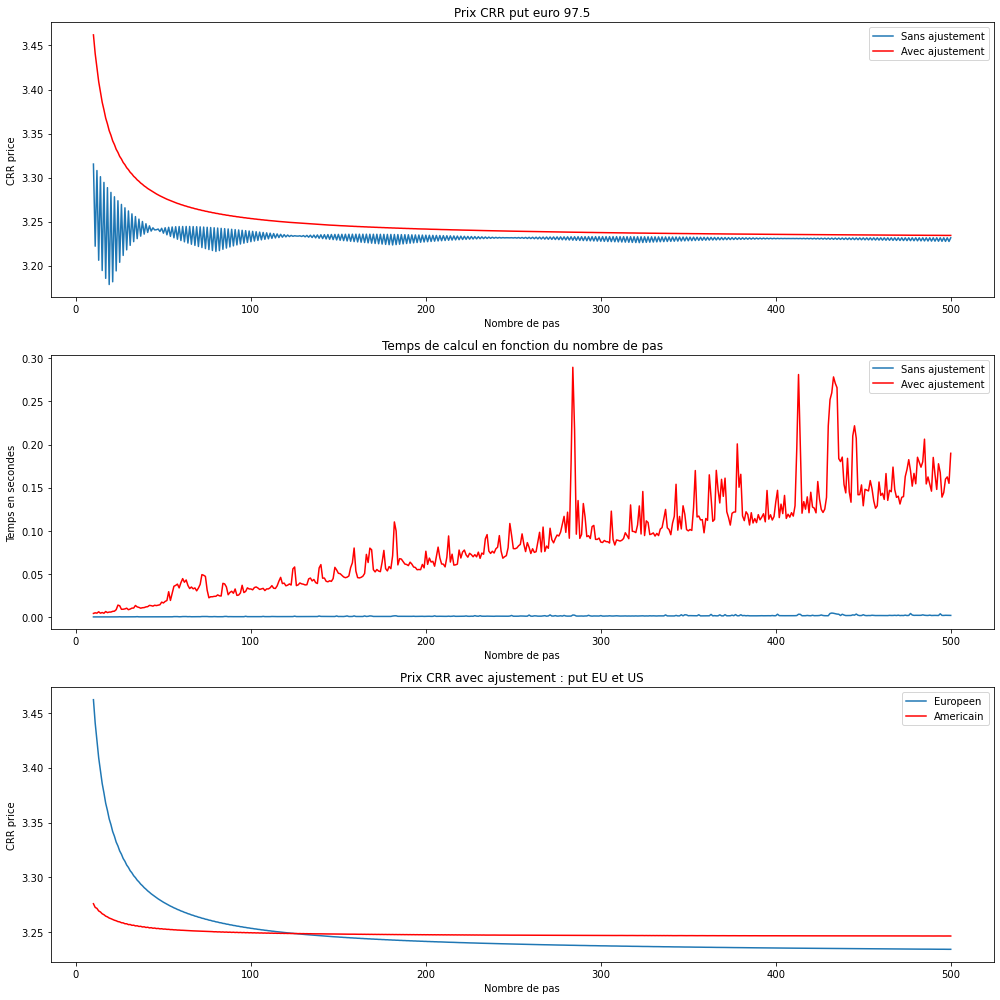

In [10]:
put975, put975_AJ, tems_calcul, temps_calcul_AJ = np.empty([491]),np.empty([491]),np.empty([491]),np.empty([491])

###Boucle pour calculer et stocker le temps de calcul des prix puts européens par CRR ajusté et non-ajusté
for n in vec_pas : 
    start = tm.time()
    put975[n-10] = put_binomial(S_TP, T_TP, 97.5,r_TP, IV6, n, 'e', 'no')
    tems_calcul[n-10]= tm.time() - start
    start = tm.time()
    put975_AJ[n-10] = put_binomial(S_TP, T_TP, 97.5,r_TP, IV6, n, 'e', 'yes')
    temps_calcul_AJ[n-10] = tm.time() - start

##Calcul du prix du put americain avec CRR avec ajustement    
am_put975 = [put_binomial(S_TP, T_TP, 97.5,r_TP, IV6, n, 'a', 'yes') for n in vec_pas]

fig,ax= plt.subplots(3,1,figsize=(14,14))
ax0,ax1,ax2=ax.flatten()

ax0.plot(vec_pas,put975,vec_pas,put975_AJ,'r')
ax0.legend(["Sans ajustement","Avec ajustement"])
ax0.set_xlabel("Nombre de pas")
ax0.set_ylabel("CRR price")
ax0.set_title("Prix CRR put euro 97.5")

ax1.plot(vec_pas,tems_calcul,vec_pas,temps_calcul_AJ,'r')
ax1.legend(["Sans ajustement","Avec ajustement"])
ax1.set_xlabel("Nombre de pas")
ax1.set_ylabel("Temps en secondes")
ax1.set_title("Temps de calcul en fonction du nombre de pas")

ax2.plot(vec_pas,put975_AJ,vec_pas,am_put975,'r')
ax2.legend(["Europeen","Americain"])
ax2.set_xlabel("Nombre de pas")
ax2.set_ylabel("CRR price")
ax2.set_title("Prix CRR avec ajustement : put EU et US")
plt.tight_layout()
plt.show()

1) On remarque que pour les options européennes, l'utilisation de l'ajustement détériore la convergence de l'arbre binomiale, il est donc préférable d'utiliser uniquement l'arbre binomial. Le prix obtenu via BMS est de 3.22 et l'arbre y converge assez rapidement alors que la méthode avec ajustement prend plus de temps pour y converger et estime de facon moins bonne le prix par BMS. 
On rappele qu'il a été prouvé que l'ajustement améliorer la convergence dans le cas américain et non pas européen. 

2) On remarque que le temps de calcul avec ajustement augmente beaucoup plus rapidement avec l'augmentation du nombre de pas que dans le cas sans ajustement. Pour le cas sans ajustement il est aux alentours de 0.0 secondes sur l'intervalle (0;500) pas alors que pour le cas avec ajustement il atteint 0.1 secondes aux alentours de 380 pas et augmente de facon presque linéaire et rapidement. 
Ainsi un autre point faible de la méthode d'ajustement est qu'elle est trés exigente en temps de calcul car plus il y a de noeuds, plus on va utiliser la fonction BMS pour calculer les valeurs a T-1. 

3) De plus on remarque que le prix du put américain présente une convergence plus rapide et beaucoup plus stable que le cas européen : avec 100 pas le prix de l'option européenne est plus grand le put américain ce qui n'est pas possible, par la suite aux alentours de 125 pas le prix de l'européenne passe en dessous du prix de l'américaine et converge jusqu'a se stabiliser. 
Le prix de l'européenne passe de 3,45 avec peu pas de pas a 3,2 avec plus de pas alors que l'américaine commence autour de 3,27 et convergve vers 3,25. Ainsi cela confirme la performance de l'ajustement dans le cas des options américaines. 

Question 5 : Frontière d'exercice (Notez que notre fonction prend environ 3 heures a rouler sur Spyder), nous avons mis l'output en image. 

Pour cette question, nous avons utilisé le fait que la frontière d'exercice Bt soit solution de l'équation suivante: 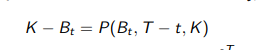

En effet, pour un soucis de précision, nous avons voulu trouver la valeur exacte et optimale pour laquelle il était optimal d'exercer l'option de façon anticipée pour chaque maturité résiduelle. Dans un soucis de granularité, nous avons divisé notre maturitétotale (horizon de temps T) en 500 maturités résiduelles t pour lesquelles nous avons trouvé pour chacune la valeur optimale Bt qui solutionne l'équation du haut. Notre frontière est conséquemment très lisse, dans ce sens ou chacun des Bt trouvés correspond au premier prix EXACT S* auquel il est optimal d'exercer pour chaque maturité résiduelle. Nous avons utilisé ici la fonction opt.fsolve comme root-finding algorithme, car les méthodes de bracketing et de dérivés ne convergent pas. La partie droite de l'équation ci-haut(prix du put américain) est calculée, dans notre fonction B définie plus haut,  avec notre arbre binomial à 500 pas avec ajustement pour chaque maturité résiduelle. La recherche des racines Bt pour chaque maturité résiduelle t et pour chacune des volatilités historiques 30 et 40 % nous a pris plusieurs heures d'optimisation, raison pour laquelle nous avons directement inséré l'image des graphiques résultants. A des fins de tester le code avec une durée plus raisonable, l'utilisateur pourrait changer le nombre de pas des arbres binomiaux utilisés (50 au lieu de 500) dans l'optimisation de B par opt.fsolve. Il pourrait également réduire le nombre de maturités résiduelles utilisées dans la première ligne du code ci-dessous.

In [ ]:
matres = T_TP - np.arange(0,T_TP,T_TP/500) # vecteur de maturités résiduelles ; diminuer le nombre en changeant la valeur 500  pour tester le code dans un temps raisonnable
vec_K = [92.5,97.5,102.5,107.5]
of = [[], [], [], []] # Vecteur qui contiendra les la frontiere d'exercice pour 
of40 = [[], [], [], []]

##BOUCLE QUI RESOUD L'EQUATION MENTIONNEE PLUS HAUT POUR RETROUVER Bt a chacune des 500 maturités résiduelles, avec un arbre binomial a 500 pas
j = 0
for i in vec_K:
    of[j] = [opt.fsolve(B, 100,args=(tau, i,0.03, 0.35, 500, 'a', 'yes')) for tau in matres] ##changer le nombre de pas de 500 a 50 pour tester lecode dans une durée raisonable 
    of40[j] = [opt.fsolve(B, 100,args=(tau, i,0.03, 0.4, 500, 'a', 'yes')) for tau in matres]##changer le nombre de pas de 500 a 50 pour tester lecode dans une durée raisonable 
    j = j+1


fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(14,14))
ax0,ax1,ax2,ax3=ax.flatten()

ax0.plot(matres,of[0],matres,of40[0],'r')
ax0.legend(["vol = 35%","vol = 40%"])
ax0.set_xlabel("maturité résiduelle")
ax0.set_ylabel("Prix optimal d'exercice")
ax0.set_title("K = 92.5")



ax1.plot(matres,of[1],matres,of40[1],'r')
ax1.legend(["vol = 35%","vol = 40%"])
ax1.set_xlabel("maturité résiduelle")
ax1.set_ylabel("Prix optimal d'exercice")
ax1.set_title("K = 97.5")

ax2.plot(matres,of[2],matres,of40[2],'r')
ax2.legend(["vol = 35%","vol = 40%"])
ax2.set_xlabel("maturité résiduelle")
ax2.set_ylabel("Prix optimal d'exercice")
ax2.set_title("K = 102.5")


ax3.plot(matres,of[3],matres,of40[3],'r')
ax3.legend(["vol = 35%","vol = 40%"])
ax3.set_xlabel("maturité résiduelle")
ax3.set_ylabel("Prix optimal d'exercice")
ax3.set_title("K = 107.5")
fig.tight_layout()
plt.show()

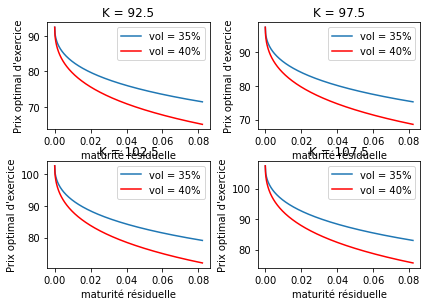

On remarque que dans le cas ou la volatilité augmente a 40%, notre frontière d'exercice devient plus basse, ceci dit qu'a maturité constante, nous devenons plus exigeant car du a la volatilité plus forte il est plus probable que le prix fluctue et qu'on puisse exerce a un meilleur prix donc on est plus patient et on demande un prix plus faible qu'avec une volatilité de 35% avant qu'il devienne optimal d'exercer notre option. 

Et vice-versa si la volatilité est faible, on est moins exigeant et l'optimalité de l'exercice de l'option est liée a un prix plus élevé qu'en cas de forte volatilité. 

Question 6 : Frontière d'exercice en utilisant la forme quasi-analytique de Carr-Jarrow-Myneni

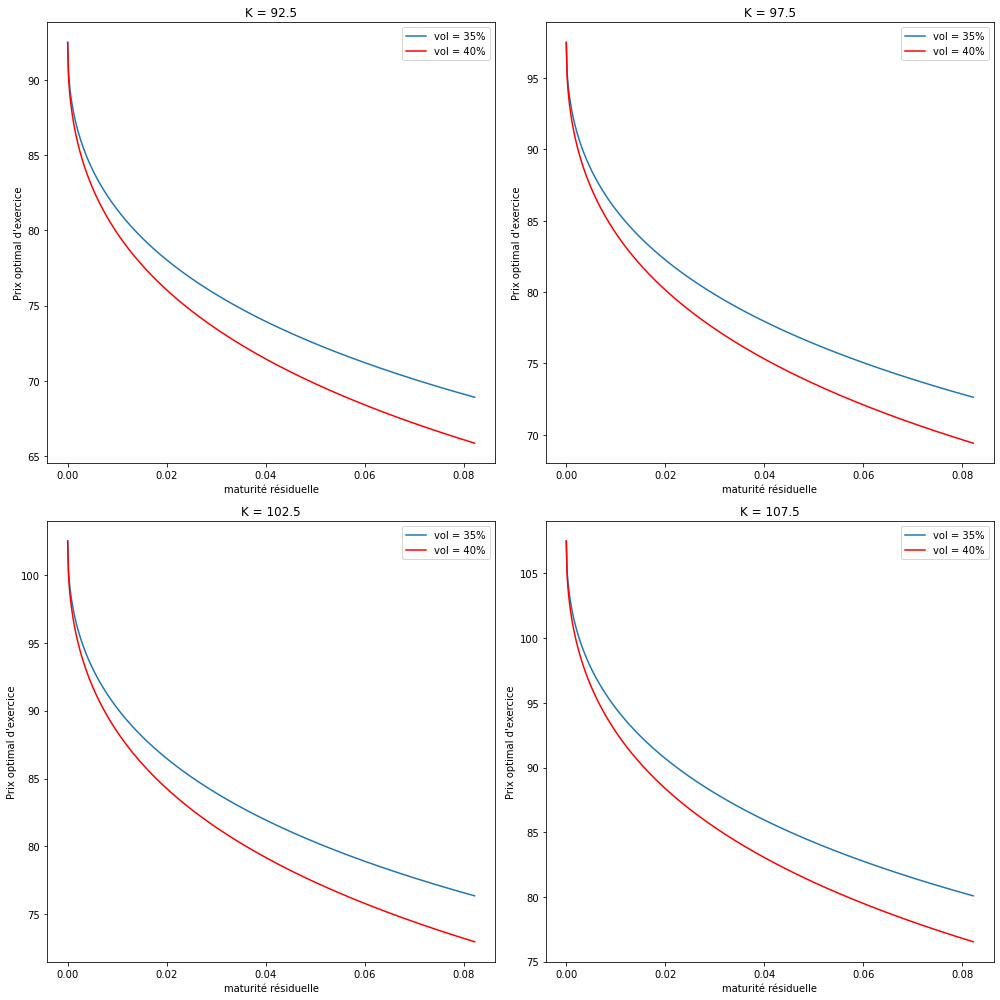

In [11]:
matres = T_TP - np.arange(0,T_TP,T_TP/500)
vec_K = [92.5,97.5,102.5,107.5]
of = [[], [], [], []]
of40 = [[], [], [], []]


op_frontier = [[], [], [], []]
op_frontier40 = [[], [], [], []]

j =0
for i in vec_K:
    op_frontier[j]= [Bt(i,r_TP,vol_hist,tau) for tau in matres]
    op_frontier40[j]= [Bt(i,r_TP,0.4,tau) for tau in matres]
    j = j+1


fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(14,14))
ax0,ax1,ax2,ax3=ax.flatten()
fig.tight_layout()

ax0.plot(matres,op_frontier[0],matres,op_frontier40[0],'r')
ax0.legend(["vol = 35%","vol = 40%"])
ax0.set_xlabel("maturité résiduelle")
ax0.set_ylabel("Prix optimal d'exercice")
ax0.set_title("K = 92.5")



ax1.plot(matres,op_frontier[1],matres,op_frontier40[1],'r')
ax1.legend(["vol = 35%","vol = 40%"])
ax1.set_xlabel("maturité résiduelle")
ax1.set_ylabel("Prix optimal d'exercice")
ax1.set_title("K = 97.5")

ax2.plot(matres,op_frontier[2],matres,op_frontier40[2],'r')
ax2.legend(["vol = 35%","vol = 40%"])
ax2.set_xlabel("maturité résiduelle")
ax2.set_ylabel("Prix optimal d'exercice")
ax2.set_title("K = 102.5")


ax3.plot(matres,op_frontier[3],matres,op_frontier40[3],'r')
ax3.legend(["vol = 35%","vol = 40%"])
ax3.set_xlabel("maturité résiduelle")
ax3.set_ylabel("Prix optimal d'exercice")
ax3.set_title("K = 107.5")
plt.tight_layout()
plt.show()

Il nous sembre que les frontières d'exercices sont assez similaires, du fait qu'on a smoothé notre frontière d'exercice a la question 5. Nous sommes conscient qu'en utilisant juste l'arbre binomial et l'interpolation notre réponse a la question 5 aura été sous forme d'escalier mais du fait qu'on a amélioré notre frontière d'exercice a la question 5 nous obtenons des frontières assez similaires. 